# Modelos de sinapsis estáticas y dinámicas


In [ ]:
# @title Instalen e importen el dispositivo de respuesta

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W2D3_T3"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00


In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# @title Configuraciones de figura
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format='retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

In [ ]:
# @title Funciones de graficar

def my_illus_LIFSYN(pars, v_fmp, v):
  """
  Illustartion of FMP and membrane voltage

  Args:
    pars  : parameters dictionary
    v_fmp : free membrane potential, mV
    v     : membrane voltage, mV

  Returns:
    plot of membrane voltage and FMP, alongside with the spiking threshold
    and the mean FMP (dashed lines)
  """

  plt.figure(figsize=(14, 5))
  plt.plot(pars['range_t'], v_fmp, 'r', lw=1.,
           label='Free mem. pot.', zorder=2)
  plt.plot(pars['range_t'], v, 'b', lw=1.,
           label='True mem. pot', zorder=1, alpha=0.7)
  plt.axhline(pars['V_th'], 0, 1, color='k', lw=2., ls='--',
              label='Spike Threshold', zorder=1)
  plt.axhline(np.mean(v_fmp), 0, 1, color='r', lw=2., ls='--',
              label='Mean Free Mem. Pot.', zorder=1)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(loc=[1.02, 0.68])
  plt.show()


def plot_volt_trace(pars, v, sp, show=True):
  """
  Plot trajetory of membrane potential for a single neuron

  Args:
    pars   : parameter dictionary
    v      : volt trajetory
    sp     : spike train

  Returns:
    figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt = pars['dt']
  if sp.size:
    sp_num = (sp/dt).astype(int) - 1
    v[sp_num] += 10

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--', lw=1.)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  if show:
    plt.show()


def my_illus_STD(Poisson=False, rate=20., U0=0.5,
                 tau_d=100., tau_f=50., plot_out=True):
  """
   Only for one presynaptic train

  Args:
    Poisson    : Poisson or regular input spiking trains
    rate       : Rate of input spikes, Hz
    U0         : synaptic release probability at rest
    tau_d      : synaptic depression time constant of x [ms]
    tau_f      : synaptic facilitation time constantr of u [ms]
    plot_out   : whether ot not to plot, True or False

  Returns:
    Nothing.
  """

  T_simu = 10.0 * 1000 / (1.0 * rate)  # 10 spikes in the time window
  pars = default_pars(T=T_simu)
  dt = pars['dt']

  if Poisson:
    # Poisson type spike train
    pre_spike_train = Poisson_generator(pars, rate, n=1)
    pre_spike_train = pre_spike_train.sum(axis=0)
  else:
    # Regular firing rate
    isi_num = int((1e3/rate)/dt)  # number of dt
    pre_spike_train = np.zeros(len(pars['range_t']))
    pre_spike_train[::isi_num] = 1.

  u, R, g = dynamic_syn(g_bar=1.2, tau_syn=5., U0=U0,
                        tau_d=tau_d, tau_f=tau_f,
                        pre_spike_train=pre_spike_train,
                        dt=pars['dt'])

  if plot_out:
    plt.figure(figsize=(12, 6))

    plt.subplot(221)
    plt.plot(pars['range_t'], R, 'b', label='R')
    plt.plot(pars['range_t'], u, 'r', label='u')
    plt.legend(loc='best')
    plt.xlim((0, pars['T']))
    plt.ylabel(r'$R$ or $u$ (a.u)')
    plt.subplot(223)
    spT = pre_spike_train > 0
    t_sp = pars['range_t'][spT]  #spike times
    plt.plot(t_sp, 0. * np.ones(len(t_sp)), 'k|', ms=18, markeredgewidth=2)
    plt.xlabel('Time (ms)');
    plt.xlim((0, pars['T']))
    plt.yticks([])
    plt.title('Presynaptic spikes')

    plt.subplot(122)
    plt.plot(pars['range_t'], g, 'r', label='STP synapse')
    plt.xlabel('Time (ms)')
    plt.ylabel('g (nS)')
    plt.xlim((0, pars['T']))

    plt.tight_layout()
    plt.show()

  if not Poisson:
    return g[isi_num], g[9*isi_num]

In [ ]:
# @title Funciones de ayuda

def my_GWN(pars, mu, sig, myseed=False):
  """
  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                  the same seed will give the same random number sequence

  Returns:
    I          : Gaussian White Noise (GWN) input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  # you can fix the seed of the random number generator so that the results
  # are reliable. However, when you want to generate multiple realizations
  # make sure that you change the seed for each new realization.
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to seconds.
  I_GWN = mu + sig * np.random.randn(Lt) / np.sqrt(dt / 1000.)

  return I_GWN


def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train


def default_pars(**kwargs):
  pars = {}

  ### typical neuron parameters###
  pars['V_th'] = -55.    # spike threshold [mV]
  pars['V_reset'] = -75. # reset potential [mV]
  pars['tau_m'] = 10.    # membrane time constant [ms]
  pars['g_L'] = 10.      # leak conductance [nS]
  pars['V_init'] = -65.  # initial potential [mV]
  pars['E_L'] = -75.     # leak reversal potential [mV]
  pars['tref'] = 2.      # refractory time (ms)

  ### simulation parameters ###
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  ### external parameters if any ###
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars

En las `Funciones de ayuda`:

- Generador de ruido blanco Gaussiano: `my_GWN(pars, mu, sig, myseed=False)`
- Generador de trenes de spikes de Poisson: `Poisson_generator(pars, rate, n, myseed=False)`
- Función de parámetros default (la misma que antes)

---
# Sección 1: Sinapsis estáticas

## Sección 1.1: Simulando dinámicas de conductancia sináptica

Los estímulos sinápticos _en vivo_ consisten de una serie de neurotransmisores **excitatorios**, los cuales despolarizan la célula y la llevan al umbral de las espigas, y los neurotransmisores **inhibitorios** que la hiperpolarizan, alejandola del umbral de las espigas. Estos químicos causan que se abran canales específicos de hierro en la neurona postsináptica, resultando en un cambió de la conductancia de la neurona y, por tanto, en la corriente adentro o afuera de la célula.   


Este proceso se puede modelar asumiendo que la actividad de espigas de la neurona presináptica genera cambios transitorios en la conductancia de la neurona postsináptica ($g_{\rm syn}(t)$). Típicamente la conductancia transitoria se modela como una función exponencial.


Dichas conductancias transitorias pueden generarse utilizando ecuaciones diferenciales ordinarias (ODE):


<br>


\begin{equation}
\frac{dg_{\rm syn}(t)}{dt} = {g}_{\rm syn_{max}} \sum_k \delta(t-t_k) -g_{\rm syn}(t)/\tau_{\rm syn}
\end{equation}


<br>


Donde ${g}_{\rm syn_{max}}$ (Muchas veces llamado peso sináptico) es el cambio de conductancia máximo provocado por cada spike y $\tau_{\rm syn}$ es la constante sináptica de tiempo. Noten que la sumatoria corre por todos las spikes recibidas por la neurona en el tiempo $t_k$.


La ley de Ohm nos permite convertir cambios de conductancia a cambios de corriente de la siguiente forma:


<br>


\begin{equation}
I_{\rm syn}(t) = -g_{\rm syn}(t)(V(t)-E_{\rm syn})  \\
\end{equation}


<br>


El potencial de reversa $E_{\rm syn}$ determina la dirección del flujo de la corriente y la naturaleza excitatoria o inhibitoria de la sinapsis.


**Por tanto, las espigas que siguen son filtradas por un núcleo de forma exponencial, efectivamente haciendo un filtrado de paso bajo de los valores de entrada. En otras palabras, los estímulos sinápticos no son ruido blanco pero en cambio ruido de color, donde el color (espectro) del ruido se determina por las constantes de tiempo sinápticas de sinapsis tanto excitatorias como inhibitorias.**


En una red neuronal la corriente sináptica de entrada total $I_{\rm syn}$ es la sumatoria de valores de entrada excitatorios e inhibitorios. Asumiendo que el total de las conductancias excitatorias e inhibitorias recibidas en el tiempo $t$ es $g_E(t)$ y $g_I(t)$, y que sus correspondientes potenciales de reversa son $E_E$ y $E_I$,respectivamente, entonces la corriente sináptica total se puede descubrir así:


<br>


\begin{equation}
I_{\rm syn}(V(t),t) = -g_E(t) (V-E_E) - g_I(t) (V-E_I)
\end{equation}


<br>


De forma acorde, las dinámicas del potencial de membrana de la neurona LIF bajo dirección de la corriente se vuelven:


<br>


\begin{equation}
\tau_m\frac{dV(t)}{dt} = -(V(t)-E_L) - \frac{g_E(t)}{g_L} (V(t)-E_E) - \frac{g_I(t)}{g_L} (V(t)-E_I) + \frac{I_{\rm inj}}{g_L}\quad (2)
\end{equation}


<br>


$I_{\rm inj}$ es una corriente externa inyectada en la neurona, la cual está bajo control experimental; puede ser GWN, DC o cualquier otra.


Vamos a usar la ecuación (2) para simular el modelo de neurona LIF basado en la conductancia debajo.


En los tutoriales previos hemos visto cómo los valores de salida de una sola neurona (ritmo de disparo, contador de espigas e irregularidades en el tiempo de espigas) cambian cuando estimulas a la neurona con DC y GWN, respectivamente. Ahora estamos en una posición de estudiar cómo se comporta una neurona cuando es bombardeada por trenes de espigas excitatorios o inhibitorios -- como sucede *en vivo*.


¿Qué clase de estímulos está recibiendo una neurona? Cuando no sabemos elegimos la opción más sencilla. El modelo más sencillo de espigas de entrada se da cuando cada espiga de entrada llega independientemente de las otras, i.e., cuando asumimos que el estímulo es de Poisson.


## Sección 1.2: Simular la neurona LIF con sinapsis basadas en la conductancia

Ahora estamos listos para simular una neurona LIF con estimulos de sinapsis basados en conductancia! El siguiente codigo define la neurona LIF con estimulos de sinapsis modelado como conductancia transitoria.

In [ ]:
# @markdown Ejecute esta celda para obtener una función para neuronas LIF basadas en conductancia (run_LIF_cond)

def run_LIF_cond(pars, I_inj, pre_spike_train_ex, pre_spike_train_in):
  """
  Conductance-based LIF dynamics

  Args:
    pars               : parameter dictionary
    I_inj              : injected current [pA]. The injected current here
                         can be a value or an array
    pre_spike_train_ex : spike train input from presynaptic excitatory neuron
    pre_spike_train_in : spike train input from presynaptic inhibitory neuron

  Returns:
    rec_spikes         : spike times
    rec_v              : membrane potential
    gE                 : postsynaptic excitatory conductance
    gI                 : postsynaptic inhibitory conductance

  """

  # Retrieve parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  gE_bar, gI_bar = pars['gE_bar'], pars['gI_bar']
  VE, VI = pars['VE'], pars['VI']
  tau_syn_E, tau_syn_I = pars['tau_syn_E'], pars['tau_syn_I']
  tref = pars['tref']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize
  tr = 0.
  v = np.zeros(Lt)
  v[0] = V_init
  gE = np.zeros(Lt)
  gI = np.zeros(Lt)
  Iinj = I_inj * np.ones(Lt)  # ensure Iinj has length Lt

  if pre_spike_train_ex.max() == 0:
    pre_spike_train_ex_total = np.zeros(Lt)
  else:
    pre_spike_train_ex_total = pre_spike_train_ex.sum(axis=0) * np.ones(Lt)

  if pre_spike_train_in.max() == 0:
    pre_spike_train_in_total = np.zeros(Lt)
  else:
    pre_spike_train_in_total = pre_spike_train_in.sum(axis=0) * np.ones(Lt)

  # simulation
  rec_spikes = []  # recording spike times
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # update the synaptic conductance
    gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + gE_bar * pre_spike_train_ex_total[it + 1]
    gI[it + 1] = gI[it] - (dt / tau_syn_I) * gI[it] + gI_bar * pre_spike_train_in_total[it + 1]

    # calculate the increment of the membrane potential
    dv = (dt / tau_m) * (-(v[it] - E_L) \
                         - (gE[it + 1] / g_L) * (v[it] - VE) \
                         - (gI[it + 1] / g_L) * (v[it] - VI) + Iinj[it] / g_L)

    # update membrane potential
    v[it+1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes, gE, gI


print(help(run_LIF_cond))

Help on function run_LIF_cond in module __main__:

run_LIF_cond(pars, I_inj, pre_spike_train_ex, pre_spike_train_in)
    Conductance-based LIF dynamics
    
    Args:
      pars               : parameter dictionary
      I_inj              : injected current [pA]. The injected current here
                           can be a value or an array
      pre_spike_train_ex : spike train input from presynaptic excitatory neuron
      pre_spike_train_in : spike train input from presynaptic inhibitory neuron
    
    Returns:
      rec_spikes         : spike times
      rec_v              : membrane potential
      gE                 : postsynaptic excitatory conductance
      gI                 : postsynaptic inhibitory conductance

None


### Ejercicio de programación 1.2: Medir el potencial de membrana libre medio

Simulemos la neurona LIF basada en la conductancia con trenes de espigas presinápticos generados por un `Poisson_generator` con un ritmo de 10 Hz para estímulos excitatorios e inhibitorios. Acá elegimos 80 trenes de espigas presinápticas excitatorios y 20 inhibitorios.

Previamente hemos aprendido que $CV_{\rm ISI}$ puede describir la irregularidad del patrón de espigas de salida. Ahora vamos a introducir un nuevo descriptor de la membrana de la neurona, i.e., el **Potencial libre de membrana (FMP)** -- el potencial de membrana de la neurona cuando el umbral de espigas es removido.

Aunque esta idea es completamente artificial calcular la cantidad nos permite darnos una idea de que tan fuerte es el estimulo. Nos interesa principalmente saber la desviación media y estandar (std.) del FMP. En este ejercicio pueden visualizar el FMP y el voltaje de la membrana con el umbral de espigas.


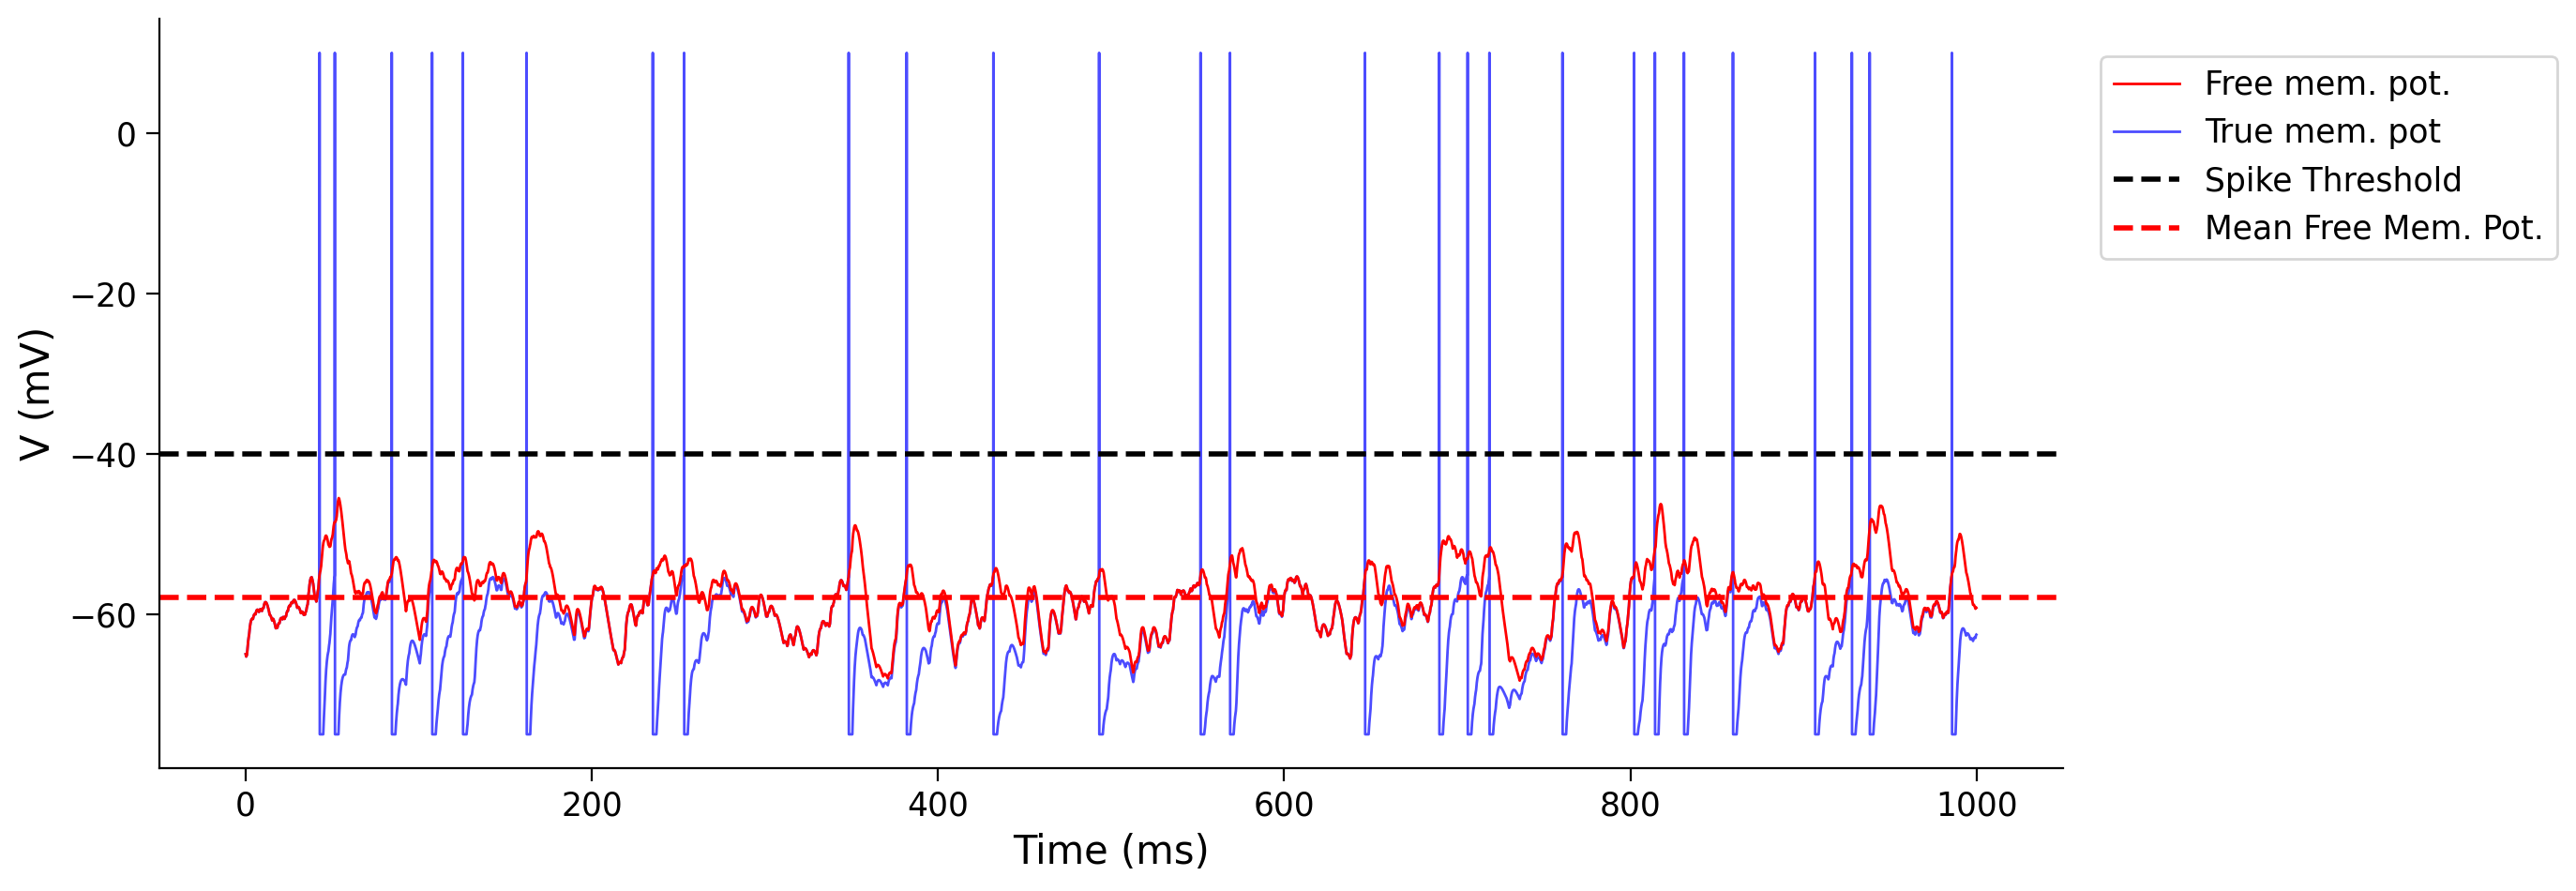

In [ ]:
# Get default parameters
pars = default_pars(T=1000.)

# Add parameters
pars['gE_bar'] = 2.4    # [nS] Aumentos de conductancia cuando hay un spike de neurona excitatoria
pars['VE'] = 0.         # [mV] excitatory reversal potential
pars['tau_syn_E'] = 2.  # [ms]
pars['gI_bar'] = 2.4    # [nS] Aumentos de conductancia cuando hay un spike de neurona inhibitoria
pars['VI'] = -80.       # [mV] inhibitory reversal potential
pars['tau_syn_I'] = 5.  # [ms]
pars['V_th'] = -55.0    # [mV] threshold default
# Generate presynaptic spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=80)
pre_spike_train_in = Poisson_generator(pars, rate=10, n=20)

# Simulate conductance-based LIF model
v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)

# Show spikes more clearly by setting voltage high
dt, range_t = pars['dt'], pars['range_t']
if rec_spikes.size:
  sp_num = (rec_spikes / dt).astype(int) - 1
  v[sp_num] = 10   # draw nicer spikes

####################################################################
## TODO for students: measure the free membrane potential
# In order to measure the free membrane potential, first,
# you should prevent the firing of the LIF neuron
# How to prevent a LIF neuron from firing? Increase the threshold pars['V_th'].
####################################################################

# Change the threshold
pars['V_th'] = -40#1e2

# Calculate FMP
v_fmp, _, _, _ = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)

my_illus_LIFSYN(pars, v_fmp, v)

### Demo interactiva 1.2: Explorador de LIF basado en la conductancia con diferentes estímulos E/I

De forma siguiente vamos a investigar cómo cambiar el ratio de estímulos excitatorios a inhibitorios cambia el ritmo de disparo y la regularidad en el tiempo de las espigas (miren el texto de salida).

Para cambiar tanto los estímulos excitatorios como los inhibitorios vamos a cambiar sus ritmos de disparo. *Sin embargo, si gustan, pueden variar la fuerza o número de estas conexiones también.*

Presten atención al potencial libre de membrana medio (la línea a puntos roja) y su ubicación en relación al umbral de las espigas (la línea a puntos negra).

¿Hay alguna relación entre el medio del FMP y la irregularidad en el tiempo de espigas ($CV_{\rm ISI}$)? ¿Que pasa cuando el medio del FMP esta arriba del umbral de espigas vs por debajo?

In [ ]:
# @markdown Asegúrese de ejecutar esta celda para habilitar el dispositivo!

my_layout.width = '450px'
@widgets.interact(
    inh_rate=widgets.FloatSlider(20., min=0., max=60., step=5.,
                                 layout=my_layout),
    exc_rate=widgets.FloatSlider(10., min=0, max=20., step=2.,
                                 layout=my_layout)
)


def EI_isi_regularity(exc_rate, inh_rate):

  pars = default_pars(T=1000.)
  # Add parameters
  pars['gE_bar'] = 3.     # [nS]
  pars['VE'] = 0.         # [mV] excitatory reversal potential
  pars['tau_syn_E'] = 2.  # [ms]
  pars['gI_bar'] = 3.     # [nS]
  pars['VI'] = -80.       # [mV] inhibitory reversal potential
  pars['tau_syn_I'] = 5.  # [ms]

  pre_spike_train_ex = Poisson_generator(pars, rate=exc_rate, n=80)
  pre_spike_train_in = Poisson_generator(pars, rate=inh_rate, n=20)  # 4:1

  # Lets first simulate a neuron with identical input but with no spike
  # threshold by setting the threshold to a very high value
  # so that we can look at the free membrane potential
  pars['V_th'] = 1e3
  v_fmp, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                           pre_spike_train_in)

  # Now simulate a LIP with a regular spike threshold
  pars['V_th'] = -55.
  v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex,
                                       pre_spike_train_in)
  dt, range_t = pars['dt'], pars['range_t']
  if rec_spikes.size:
      sp_num = (rec_spikes / dt).astype(int) - 1
      v[sp_num] = 10  # draw nicer spikes

  spike_rate = 1e3 * len(rec_spikes) / pars['T']

  cv_isi = 0.
  if len(rec_spikes) > 3:
    isi = np.diff(rec_spikes)
    cv_isi = np.std(isi) / np.mean(isi)

  print('\n')
  plt.figure(figsize=(15, 10))
  plt.subplot(211)
  plt.text(500, -35, f'Spike rate = {spike_rate:.3f} (sp/s), Mean of Free Mem Pot = {np.mean(v_fmp):.3f}',
           fontsize=16, fontweight='bold', horizontalalignment='center',
           verticalalignment='bottom')
  plt.text(500, -38.5, f'CV ISI = {cv_isi:.3f}, STD of Free Mem Pot = {np.std(v_fmp):.3f}',
           fontsize=16, fontweight='bold', horizontalalignment='center',
           verticalalignment='bottom')

  plt.plot(pars['range_t'], v_fmp, 'r', lw=1.,
           label='Free mem. pot.', zorder=2)
  plt.plot(pars['range_t'], v, 'b', lw=1.,
           label='mem. pot with spk thr', zorder=1, alpha=0.7)
  plt.axhline(pars['V_th'], 0, 1, color='k', lw=1., ls='--',
              label='Spike Threshold', zorder=1)
  plt.axhline(np.mean(v_fmp),0, 1, color='r', lw=1., ls='--',
              label='Mean Free Mem. Pot.', zorder=1)
  plt.ylim(-76, -39)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(loc=[1.02, 0.68])

  plt.subplot(223)
  plt.plot(pars['range_t'][::3], gE[::3], 'r', lw=1)
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_E$ (nS)')

  plt.subplot(224)
  plt.plot(pars['range_t'][::3], gI[::3], 'b', lw=1)
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_I$ (nS)')

  plt.tight_layout()
  plt.show()

[*Haga click para ver la solución*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W2D3_BiologicalNeuronModels/solutions/W2D3_Tutorial3_Solution_56868691.py)



### Piensa! 1.2: Balance excitatorio e inhibitorio

1. ¿Cuanto pueden aumentar la variabilidad del patrón de espigas? ¿Bajo que condición/es puede que la neurona responda con espigas del tipo Poisson? Noten que inyectamos espigas de tipo Poisson. (Piensen en la respuesta en terminos del ratio de las espigas de entrada excitatorias e inhibitorias).

2. Link al balance de excitación e inhibición: Una de las definiciones del balance de excitación e inhibición es que el potencial libre medio de membrana se mantiene constante a medida que se incrementan los ritmos de entrada inhibitorios y excitatorios. ¿Que piensan que le ocurre al ritmo de disparo de la neurona a medida que cambiamos los ritmos de excitación e inhibición mientras mantenemos a la neurona en equilibrio? Vean [Kuhn, Aertsen, and Rotter (2004)](https://www.jneurosci.org/content/jneuro/24/10/2345.full.pdf) para más información de este tema.

[*Haga click para ver la solución*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W2D3_BiologicalNeuronModels/solutions/W2D3_Tutorial3_Solution_97eecefd.py)



---
# Sección 2: Plasticidad sináptica a corto plazo


Arriba hemos modelado sinapsis con pesos fijos. Ahora vamos a explorar sinapsis cuyos pesos cambian en algunas condiciones de entrada.


La plasticidad a corto plazo (STP) es un fenómeno en el cual la eficacia sináptica cambia sobre el tiempo de una forma que refleja la historia de actividad presináptica. Dos tipos de STP, con efectos opuestos en eficacia sináptica han sido observados experimentalmente. Estos se conocen como depresión a corto plazo (STD) y facilitación a corto plazo (STF).


El modelo matemático (_por mas información hacer click [acá](http://www.scholarpedia.org/article/Short-term_synaptic_plasticity)_) de STP se basa en el concepto de un catalogo limitado de recursos disponibles para la transmisión($R$), como, por ejemplo, la cantidad total de vesiculas sinápticas en las terminales presinápticas. La cantidad de cambios de recursos presinápticos de una forma dinámica dependiendo de la historia reciente de las espigas.




Siguiendo una espiga presináptica, (i) la fracción $u$ (posibilidad de liberar) del catálogo disponible para ser utilizado aumenta debido a la llegada de calcio generada por las espigas en la terminal presináptica, luego de lo que (ii) $u$ se consume para aumentar la conductancia postsináptica. Entre espigas $u$ decae a cero con constante de tiempo $\tau_f$ y $R$ se recupera a 1 con constante de tiempo $\tau_d$. En resumen, las dinámicas de STP excitatoria (subíndice $E$) son dadas por:


<br>


\begin{eqnarray}
&& \frac{du_E}{dt} &=& -\frac{u_E}{\tau_f} + U_0(1-u_E^-)\delta(t-t_{\rm sp}) \\[.5mm]
&& \frac{dR_E}{dt} &=& \frac{1-R_E}{\tau_d} - u_E^+ R_E^- \delta(t-t_{\rm sp}) \qquad (6) \\[.5mm]
&& \frac{dg_E(t)}{dt} &=& -\frac{g_E}{\tau_E} + \bar{g}_E u_E^+ R_E^- \delta(t-t_{\rm sp})
\end{eqnarray}




Donde $U_0$ es una constante determinando el incremento $u$ producido por una espiga. $u_E^-$ y $R_E^-$ denotan los valores correspondientes justo antes de que llegue la espiga mientras que $u_E^+$ hace referencia al momento justo después de la espiga. $\bar{g}_E$ denota conductancia máxima excitatoria y $g_E(t)$ se calcula para todos los tiempos de espiga $k$,
Y decae sobre el tiempo con una constante de tiempo $\tau_{E}$. Similarmente,uno puede obtener las dinámicas inhibitorias STP (i.e., por remplazar el subindice $E$ con $I$).




La interacción entre las dinámicas de $u$ y $R$ determina si el efecto conjunto de $uR$ es dominado por *depresión* o *facilitación*. En el régimen de parámetros de $\tau_d \gg \tau_f$ y para un gran $U_0$, una espiga inicial genera un gran bajón en $R$ que toma mucha tiempo en recuperarse; Por lo tanto, la sinapsis está dominada por STD. en el régimen de $\tau_d \ll \tau_f$ y para un valor chico de $U_0$, la frecuencia sináptica aumenta gradualmente con las espigas y consecuentemente, la sinapsis está dominada por STF. Este fenomenológico modelo reproduce adecuadamente la cinética de las dinámicas de sinapsis deprimidas y facilitadas observadas en varias áreas corticales.

Proveemos una función de ayuda debajo, `dynamic_syn` la cual integra las ecuaciones de arriba usando el metodo de Euler (El cual vieron ayer).




In [ ]:
# @markdown Ejecuten esta celda para obtener la función de ayuda `dynamic_syn`

def dynamic_syn(g_bar, tau_syn, U0, tau_d, tau_f, pre_spike_train, dt):
  """
  Short-term synaptic plasticity

  Args:
    g_bar           : synaptic conductance strength
    tau_syn         : synaptic time constant [ms]
    U0              : synaptic release probability at rest
    tau_d           : synaptic depression time constant of x [ms]
    tau_f           : synaptic facilitation time constantr of u [ms]
    pre_spike_train : total spike train (number) input
                      from presynaptic neuron
    dt              : time step [ms]

  Returns:
    u               : usage of releasable neurotransmitter
    R               : fraction of synaptic neurotransmitter resources available
    g               : postsynaptic conductance

  """

  Lt = len(pre_spike_train)
  # Initialize
  u = np.zeros(Lt)
  R = np.zeros(Lt)
  R[0] = 1.
  g = np.zeros(Lt)

  # simulation
  for it in range(Lt - 1):
    # Compute du
    du = -(dt / tau_f) * u[it] + U0 * (1.0 - u[it]) * pre_spike_train[it + 1]
    u[it + 1] = u[it] + du
    # Compute dR
    dR = (dt / tau_d) * (1.0 - R[it]) - u[it + 1] * R[it] * pre_spike_train[it + 1]
    R[it + 1] = R[it] + dR
    # Compute dg
    dg = -(dt / tau_syn) * g[it] + g_bar * R[it] * u[it + 1] * pre_spike_train[it + 1]
    g[it + 1] = g[it] + dg

  return u, R, g

help(dynamic_syn)

## Sección 2.1: Depresión sináptica a corto plazo (STD)


### Demo interactiva 2.1: Explorador STD con ritmo de entrada

Debajo hay una demo interactiva que muestra como la depresión sináptica a corto plazo (STD) cambia para ritmos de disparo distintos del tren de espigas presináptico y como la conductancia de amplitud sináptica $g$ cambia con cada nueva espiga hasta que alcanza un estado estacionario.

¿Cómo afecta el ritmo de disparo a la eficacia sináptica? ¿Importa si las neuronas disparan en una forma de Poisson en lugar de regularmente?

**Nota:** `Poisson=True`: para *tipo de Poisson* y `Poisson=False`: para espigas presinápticas *regulares*. Podes chequearte y luego quitarte de la casilla correspondiente.


In [ ]:
# @markdown Asegúrese de ejecutar esta celda para habilitar el widget!

my_layout.width = '450px'
@widgets.interact(
    rate=widgets.FloatSlider(10., min=10., max=100., step=5., layout=my_layout),
    Poisson=widgets.Checkbox(value=False, layout=my_layout)
)

def my_STD_diff_rate(rate, Poisson):
      _ = my_illus_STD(Poisson=Poisson, rate=rate)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W2D3_BiologicalNeuronModels/solutions/W2D3_Tutorial3_Solution_2b0155ce.py)



Una vez le pregunté a un experimentador acerca de los valores experimentales de la amplitud PSP producida por una conexión entre dos neuronas neocorticales excitatorias. Ella preguntó: "¿A qué frecuencia?" Yo estaba confundido pero ustedes entenderán su pregunta ahora que conocen que la amplitud PSP depende de la historia de espigas y, por tanto, en el ritmo de disparo de la neurona presináptica.


Acá vamos a utilizar como el ratio de la conductancia sináptica correspondiente a la primera y décima espiga cambian como una función del ritmo de disparo presináptico (Los experimentadores usualmente toman el ratio de la primera y segunda PSPs).


Para eficiencia computacional nosotros asumimos que las espigas presinápticas son regulares. Esta asunción significa que no tenemos que realizar múltiples pruebas.


In [ ]:
# @markdown Ratio de conductancia de STD para diferentes ritmos de entrada
# Regular firing rate
input_rate = np.arange(5., 40.1, 5.)
g_1 = np.zeros(len(input_rate))  # record the the PSP at 1st spike
g_2 = np.zeros(len(input_rate))  # record the the PSP at 10th spike

for ii in range(len(input_rate)):
   g_1[ii], g_2[ii] = my_illus_STD(Poisson=False, rate=input_rate[ii],
                                   plot_out=False, U0=0.5, tau_d=100., tau_f=50)

plt.figure(figsize=(11, 4.5))

plt.subplot(121)
plt.plot(input_rate, g_1, 'm-o', label='1st Spike')
plt.plot(input_rate, g_2, 'c-o', label='10th Spike')
plt.xlabel('Rate [Hz]')
plt.ylabel('Conductance [nS]')
plt.legend()

plt.subplot(122)
plt.plot(input_rate, g_2 / g_1, 'b-o')
plt.xlabel('Rate [Hz]')
plt.ylabel(r'Conductance ratio $g_{10}/g_{1}$')\

plt.tight_layout()
plt.show()

A medida que incrementamos el ritmo de entrada el ratio de la primera a la décima espiga aumenta, esto sucede porque la conductancia de la décima espiga se vuelve menor. Esto es clara evidencia de una depresión sináptica dado que usar una misma cantidad de corriente tiene un efecto menor en la neurona.


## Sección 2.2: Facilitación sináptica a corto plazo (STF)

### Demo interactiva 2.2: Explorador STF con ritmo de entrada
Debajo podemos ver una ilustración de un ejemplo de facilitación a corto plazo. Tomen nota del cambio en las variables sinápticas: `U_0`, `tau_d`, and  `tau_f`.

- Para STD, `U0=0.5, tau_d=100., tau_f=50.`

- Para STP, `U0=0.2, tau_d=100., tau_f=750.`

¿Cómo cambia la conductancia sináptica a medida que cambiamos el ritmo de entrada? ¿Qué observan en el caso de un estímulo regular y uno de tipo Poisson?

In [ ]:
# @markdown Asegurate de ejecutar esta celda para habilitar el dispositivo!

my_layout.width = '450px'
@widgets.interact(
    rate=widgets.FloatSlider(10., min=4., max=40., step=2., layout=my_layout),
    Poisson=widgets.Checkbox(value=False, layout=my_layout)
)


def my_STD_diff_rate(rate, Poisson):
  _ = my_illus_STD(Poisson=Poisson, rate=rate,
                   U0=0.2, tau_d=100., tau_f=750.)

### Piensa! 2.2: Facilitación sináptica a corto plazo vs depresión

Acá vamos a estudiar como el ratio de la conductancia sináptica correspondiente a la $1^{er}$ y $10^{ma}$ espiga cambia como una función del ritmo presináptico.

¿Por qué sucede que la conductancia del ratio de la primer y decima espiga cambia de una forma no monótona para sinapsis con STF a pesar de que decrese de forma monótona para sinapsis con STD?

In [ ]:
# @markdown Ratio de conductancia de STF con diferentes ritmos de entrada
# Regular firing rate
input_rate = np.arange(2., 40.1, 2.)
g_1 = np.zeros(len(input_rate))  # record the the PSP at 1st spike
g_2 = np.zeros(len(input_rate))  # record the the PSP at 10th spike

for ii in range(len(input_rate)):
   g_1[ii], g_2[ii] = my_illus_STD(Poisson=False, rate=input_rate[ii],
                                   plot_out=False,
                                   U0=0.2, tau_d=100., tau_f=750.)

plt.figure(figsize=(11, 4.5))

plt.subplot(121)
plt.plot(input_rate, g_1, 'm-o', label='1st Spike')
plt.plot(input_rate, g_2, 'c-o', label='10th Spike')
plt.xlabel('Rate [Hz]')
plt.ylabel('Conductance [nS]')
plt.legend()

plt.subplot(122)
plt.plot(input_rate, g_2 / g_1, 'b-o',)
plt.xlabel('Rate [Hz]')
plt.ylabel(r'Conductance ratio $g_{10}/g_{1}$')

plt.tight_layout()
plt.show()